In [1]:
from IPython.display import display
import IPython
import pandas as pd
from pandas import Series
import numpy as np
from random import randrange

from matplotlib import pyplot
import matplotlib.pyplot as plt
# from statsmodels.tsa.seasonal import seasonal_decompose

# np.float_ = np.float64
# from prophet import Prophet

import math
from typing import Any, List, Dict, AnyStr, Optional
from pathlib import Path
from glob import glob

from utils.dataset import MarketData
from utils.windowgenerator import WindowGenerator, compile_and_fit
import tensorflow as tf
import talib as ta

%load_ext autoreload
%autoreload 2

In [2]:
def calculate_rolling_mean(df, column_name, window):
    """
    Calculate the rolling mean (SMA) for a specific column in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing the time series data.
    column_name (str): The column name on which to calculate the rolling mean.
    window (int): The window size for calculating the rolling mean.
    
    Returns:
    pd.Series: A Pandas Series containing the rolling mean values.
    """
    return df[column_name].rolling(window=window).mean()

def calculate_ema(df, column_name, window):
    """
    Calculate the Exponential Moving Average (EMA) for a specific column in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing the time series data.
    column_name (str): The column name on which to calculate the EMA.
    window (int): The window size for calculating the EMA.
    
    Returns:
    pd.Series: A Pandas Series containing the EMA values.
    """
    return talib.EMA(df[column_name], timeperiod=window)

def merge_auc_cot(auction_df, cot_df):
    # Merge DataFrames
    merged_df = pd.merge_asof(auction_df, cot_df, on='Date', direction='backward')
    merged_df.ffill(inplace=True)
    merged_df.bfill(inplace=True)
    
    # Drop unnecessary columns
    merged_df.drop(["Spot Value", "Median Price"], axis=1, inplace=True)
    
    # Calculate percentage change in Auc Price
    merged_df.loc[:, 'Pct_Change_Auc_Price'] = merged_df['Auc Price'].pct_change() * 100
    merged_df = merged_df.dropna(subset=['Pct_Change_Auc_Price'])

    merged_df.dropna(inplace=True)

    return merged_df

def MA_features(merged_df):
    ### Rolling Means and Exponential Moving Averages
    merged_df['7 MA Premium/discount-settle'] = ta.SMA(merged_df['Premium/discount-settle'], timeperiod=7)
    merged_df['20 MA Premium/discount-settle'] = ta.SMA(merged_df['Premium/discount-settle'], timeperiod=20)
    merged_df['7 EMA Premium/discount-settle'] = ta.EMA(merged_df['Premium/discount-settle'], timeperiod=7)
    merged_df['20 EMA Premium/discount-settle'] = ta.EMA(merged_df['Premium/discount-settle'], timeperiod=20)
    
    merged_df['7 MA net_speculators'] = ta.SMA(merged_df['net_speculators'], timeperiod=7)
    merged_df['20 MA net_speculators'] = ta.SMA(merged_df['net_speculators'], timeperiod=20)
    merged_df['7 EMA net_speculators'] = ta.EMA(merged_df['net_speculators'], timeperiod=7)
    merged_df['20 EMA net_speculators'] = ta.EMA(merged_df['net_speculators'], timeperiod=20)
    
    merged_df['7 MA spec_long_%'] = ta.SMA(merged_df['spec_long_%'], timeperiod=7)
    merged_df['20 MA spec_long_%'] = ta.SMA(merged_df['spec_long_%'], timeperiod=20)
    
    merged_df['7 EMA spec_long_%'] = ta.EMA(merged_df['spec_long_%'], timeperiod=7)
    merged_df['20 EMA spec_long_%'] = ta.EMA(merged_df['spec_long_%'], timeperiod=20)

    return merged_df

def LAG_features(merged_df):
    ### Lagged Features
    merged_df['delta_auc'] = merged_df['Auc Price'].diff(2)
    merged_df['delta_auc_4'] = merged_df['Auc Price'].diff(4)
    merged_df['auc_T-2'] = merged_df['Auc Price'].shift(2)
    merged_df['auc_T-4'] = merged_df['Auc Price'].shift(4)

    merged_df['delta_ls'] = merged_df['Long/Short'].diff(2)
    merged_df['delta_ls_4'] = merged_df['Long/Short'].diff(4)
    merged_df['ls_T-2'] = merged_df['Long/Short'].shift(2)
    merged_df['ls_T-4'] = merged_df['Long/Short'].shift(4)
    
    merged_df['delta_net_spec_2'] = merged_df['net_speculators'].diff(2)
    merged_df['delta_net_spec_4'] = merged_df['net_speculators'].diff(4)
    merged_df['net_spec_T-2'] = merged_df['net_speculators'].shift(2)
    merged_df['net_spec_T-4'] = merged_df['net_speculators'].shift(4)

    merged_df['delta_spec_long_2'] = merged_df['spec_long_%'].diff(2)
    merged_df['delta_spec_long_4'] = merged_df['spec_long_%'].diff(4)
    merged_df['spec_long_T-2'] = merged_df['spec_long_%'].shift(2)
    merged_df['spec_long_T-4'] = merged_df['spec_long_%'].shift(4)

    merged_df['delta_spec_short_2'] = merged_df['spec_short_%'].diff(2)
    merged_df['delta_spec_short_4'] = merged_df['spec_short_%'].diff(4)
    merged_df['spec_short_T-2'] = merged_df['spec_short_%'].shift(2)
    merged_df['spec_short_T-4'] = merged_df['spec_short_%'].shift(4)

    return merged_df

def momentum_and_volatility_features(merged_df):
    ### Momentum and Volatility Features
    merged_df['RSI_Auc_Price'] = ta.RSI(merged_df['Auc Price'], timeperiod=14)
    merged_df['Momentum_Auc_Price'] = ta.MOM(merged_df['Auc Price'], timeperiod=10)
    merged_df['Volatility_Auc_Price'] = ta.STDDEV(merged_df['Auc Price'], timeperiod=5, nbdev=1)
    
    ### Additional Indicators
    merged_df['Upper_Band'], merged_df['Middle_Band'], merged_df['Lower_Band'] = ta.BBANDS(merged_df['Auc Price'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    merged_df['MACD_Auc_Price'], _, _ = ta.MACD(merged_df['Auc Price'], fastperiod=12, slowperiod=26, signalperiod=9)
    merged_df['ATR'] = ta.ATR(merged_df['Auc Price'], merged_df['Auc Price'], merged_df['Auc Price'], timeperiod=14)

    return merged_df




### Loading Dataset

In [3]:
cot_df, auction_df, eua_df, ta_df, fundamentals_df = MarketData.latest(Path('data'))
cot_df = cot_df.set_index('Date').resample('W', origin='end').mean().reset_index()
auction_df = auction_df.set_index('Date').resample('D').mean().reset_index()

print(f"COT Cols: {cot_df.columns}")
print(f"AUC Cols: {auction_df.columns}")

merged_df = merge_auc_cot(auction_df, cot_df)
merged_df = MA_features(merged_df)
merged_df = merged_df.dropna()
# merged_df = LAG_features(merged_df)
# merged_df = momentum_and_volatility_features(merged_df)

COT Cols: Index(['Date', 'net_speculators', 'spec_long_%', 'spec_short_%', 'Long/Short'], dtype='object')
AUC Cols: Index(['Date', 'Auc Price', 'Median Price', 'Cover Ratio', 'Spot Value',
       'Auction Spot Diff', 'Median Spot Diff', 'Premium/discount-settle'],
      dtype='object')


In [4]:
merged_df

,Date,Auc Price,Cover Ratio,Auction Spot Diff,Median Spot Diff,Premium/discount-settle,net_speculators,spec_long_%,spec_short_%,Long/Short,...,7 EMA Premium/discount-settle,20 EMA Premium/discount-settle,7 MA net_speculators,20 MA net_speculators,7 EMA net_speculators,20 EMA net_speculators,7 MA spec_long_%,20 MA spec_long_%,7 EMA spec_long_%,20 EMA spec_long_%
20,2018-06-24,14.78,3.45,0.08,-0.05,0.005442,49905.83,5.37,0.52,10.326923,...,0.002225,-0.001106,52343.432857,51418.3085,51844.511598,51418.308500,5.447143,5.4195,5.431493,5.419500
21,2018-06-25,15.03,3.06,-0.03,-0.06,-0.001992,49905.83,5.37,0.52,10.326923,...,0.001171,-0.001190,51937.165714,51380.1685,51359.841198,51274.262929,5.434286,5.4180,5.416120,5.414786
22,2018-06-26,14.86,2.36,0.04,-0.06,0.002699,49905.83,5.37,0.52,10.326923,...,0.001553,-0.000820,51530.898571,51342.0285,50996.338399,51143.935983,5.421429,5.4165,5.404590,5.410520
23,2018-06-27,14.86,2.36,0.04,-0.06,0.002699,49905.83,5.37,0.52,10.326923,...,0.001839,-0.000485,51124.631429,51303.8885,50723.711299,51026.021127,5.408571,5.4150,5.395942,5.406661
24,2018-06-28,15.22,2.24,-0.03,-0.08,-0.001967,49905.83,5.37,0.52,10.326923,...,0.000888,-0.000626,50718.364286,51265.7485,50519.240974,50919.336258,5.395714,5.4135,5.389457,5.403170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239,2024-07-21,64.73,2.24,0.01,-0.24,0.000155,-23378.80,5.18,8.33,0.621849,...,-0.000007,-0.000954,-18866.105714,-18933.0545,-19410.648928,-18468.219879,5.025714,5.1185,5.064821,5.092363
2240,2024-07-22,64.37,1.68,0.12,-0.23,0.001868,-23378.80,5.18,8.33,0.621849,...,0.000462,-0.000685,-19618.221429,-19041.2430,-20402.686696,-18935.894176,5.051429,5.1210,5.093615,5.100709
2241,2024-07-23,63.67,1.60,-0.05,-0.18,-0.000785,-23378.80,5.18,8.33,0.621849,...,0.000150,-0.000694,-20370.337143,-19149.4315,-21146.715022,-19359.028064,5.077143,5.1235,5.115212,5.108261
2242,2024-07-24,63.67,1.60,-0.05,-0.18,-0.000785,-23378.80,5.18,8.33,0.621849,...,-0.000083,-0.000703,-21122.452857,-19257.6200,-21704.736267,-19741.863487,5.102857,5.1260,5.131409,5.115093


In [5]:
def train_test_data(merged_df, features = []):
    print(features)
    if len(features) == 0:
        print('here')
        FEATURES = ['Auc Price', 'Cover Ratio', 'Auction Spot Diff',
       'Median Spot Diff', 'Premium/discount-settle', 'net_speculators',
       'spec_long_%', 'spec_short_%', 'Long/Short', 'Pct_Change_Auc_Price',
       'delta_auc', 'delta_auc_4', 'auc_T-2', 'auc_T-4', 'delta_ls',
       'delta_ls_4', 'ls_T-2', 'ls_T-4']
        
    else: 
        FEATURES = [feature for feature in features if feature != 'Date']
    train_df = merged_df[merged_df['Date'] <
                        "2022-06-01"].copy().set_index('Date')[FEATURES].copy()
    
    val_df = merged_df[(merged_df['Date'].dt.year == 2022) & (
        merged_df['Date'].dt.month >= 6)].copy().set_index('Date')[FEATURES].copy()
    
    test_df = merged_df[merged_df['Date'].dt.year >= 2023].copy().set_index('Date')[FEATURES].copy()

    return train_df, test_df, val_df

def normalize(train_df, test_df, val_df):
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std

    return train_df, test_df, val_df

def compile_and_fit(model, window, patience=2, MAX_EPOCHS = 20):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


FEATURES = merged_df.columns
train_df, test_df, val_df = train_test_data(merged_df, features=FEATURES)
train_df, test_df, val_df = normalize(train_df, test_df, val_df)


Index(['Date', 'Auc Price', 'Cover Ratio', 'Auction Spot Diff',
       'Median Spot Diff', 'Premium/discount-settle', 'net_speculators',
       'spec_long_%', 'spec_short_%', 'Long/Short', 'Pct_Change_Auc_Price',
       '7 MA Premium/discount-settle', '20 MA Premium/discount-settle',
       '7 EMA Premium/discount-settle', '20 EMA Premium/discount-settle',
       '7 MA net_speculators', '20 MA net_speculators',
       '7 EMA net_speculators', '20 EMA net_speculators', '7 MA spec_long_%',
       '20 MA spec_long_%', '7 EMA spec_long_%', '20 EMA spec_long_%'],
      dtype='object')


In [6]:
NUM_OF_FEATURES = train_df.shape[1]
column_indices = {name: i for i, name in enumerate(merged_df.columns)}
# LABEL_COLS = ['Premium/discount-settle']
# LABEL_COL = 'Premium/discount-settle'
LABEL_COLS = ['Auc Price']
LABEL_COL = 'Auc Price'


In [7]:

single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=LABEL_COLS,
    train_df=train_df,
    test_df=test_df,
    val_df=val_df)

single_step_window

for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 22)
Labels shape (batch, time, features): (32, 1, 1)


2024-08-28 22:14:00.566891: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### LINEAR MODELS

In [8]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]
  

baseline = Baseline(label_index=column_indices[LABEL_COL])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 2.9719 - mean_absolute_error: 1.5686


Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['Auc Price']
Input shape: (32, 7, 22)
Output shape: (32, 7, 1)


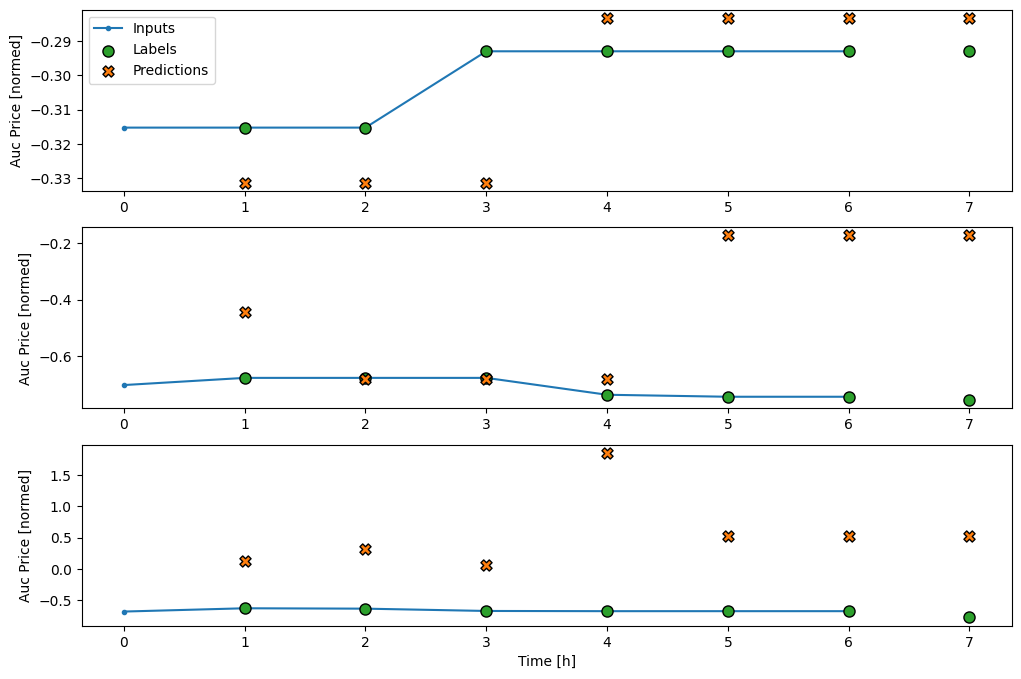

In [9]:
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1,
    label_columns=LABEL_COLS,
    train_df=train_df,
    test_df=test_df,
    val_df=val_df)

print(wide_window)
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)
wide_window.plot(baseline, plot_col=LABEL_COL)

Input shape: (32, 1, 22)
Output shape: (32, 1, 1)
Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9705 - mean_absolute_error: 0.7294 - val_loss: 2.2000 - val_mean_absolute_error: 1.2255
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 0.7356 - mean_absolute_error: 0.6302 - val_loss: 1.8576 - val_mean_absolute_error: 1.1354
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 0.5807 - mean_absolute_error: 0.5657 - val_loss: 1.5426 - val_mean_absolute_error: 1.0392
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 0.4649 - mean_absolute_error: 0.5076 - val_loss: 1.2583 - val_mean_absolute_error: 0.9391
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.3468 - mean_absolute_error: 0.4364 - val_loss: 1.0347 - val_mean_absolute_error: 0.8532
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 0.2934 - mean_absolute_error: 0.4013 - val_loss: 0.8638 - val_mean_absolute_error: 0.7846
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step 

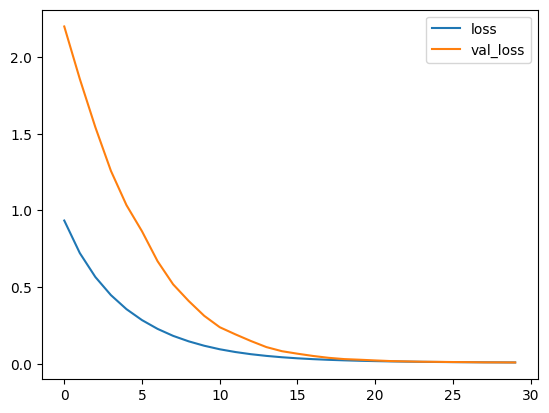

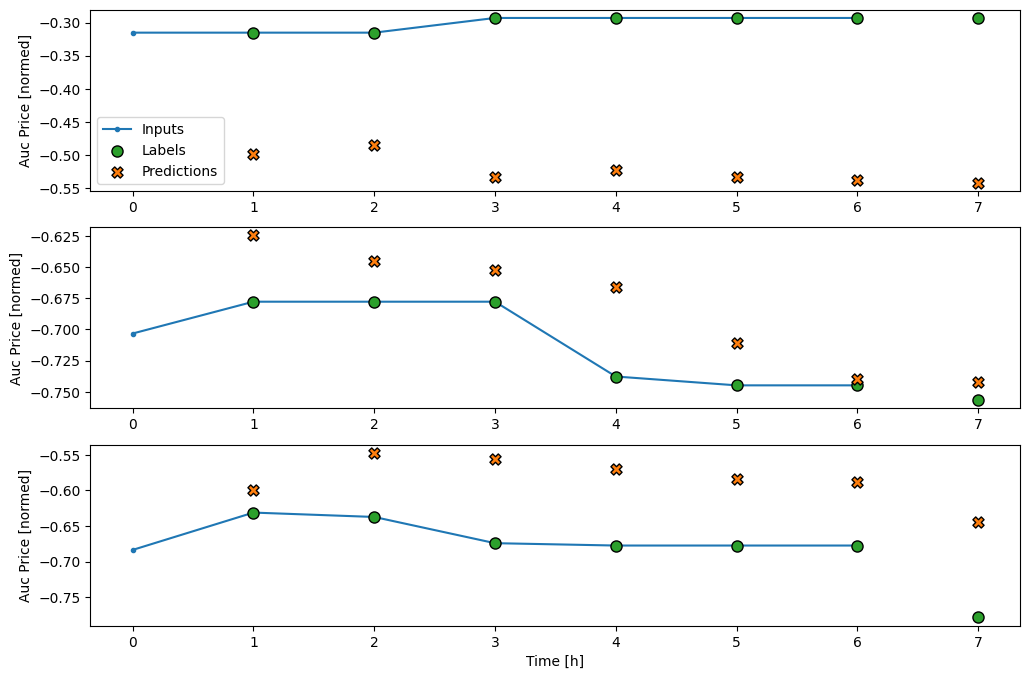

In [10]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

MAX_EPOCHS = 30


history = compile_and_fit(linear, single_step_window, MAX_EPOCHS=MAX_EPOCHS)

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

wide_window.plot(linear, plot_col=LABEL_COL)

### FEATURE IMPORTANCE

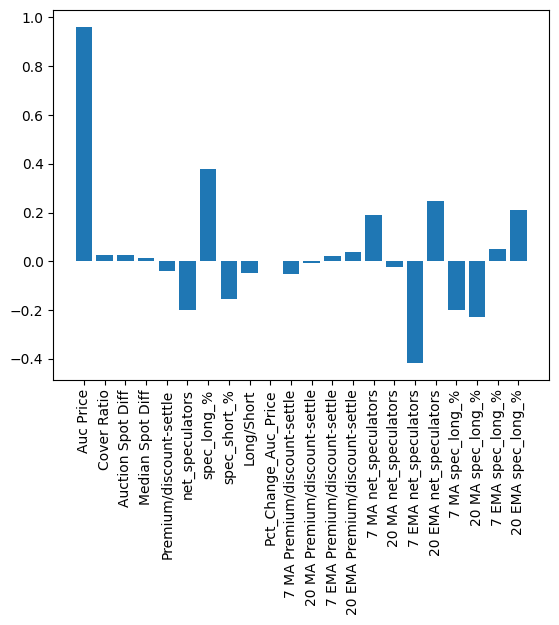

In [11]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6985 - mean_absolute_error: 0.6546 - val_loss: 0.1469 - val_mean_absolute_error: 0.3174
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 0.0565 - mean_absolute_error: 0.1729 - val_loss: 0.0532 - val_mean_absolute_error: 0.1837
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 0.0202 - mean_absolute_error: 0.1060 - val_loss: 0.0422 - val_mean_absolute_error: 0.1665
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 0.0142 - mean_absolute_error: 0.0892 - val_loss: 0.0330 - val_mean_absolute_error: 0.1487
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 0.0112 - mean_absolute_error: 0.0782 - val_loss: 0.0489 - val_mean_absolute_error: 0.1788
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 0.0093 - mean_absolute_error: 0.0730 - val_loss: 0.0264 - val_mean_absolute_error: 0.1323
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 0.0080 - mean_absolute_error: 0.0666 - val

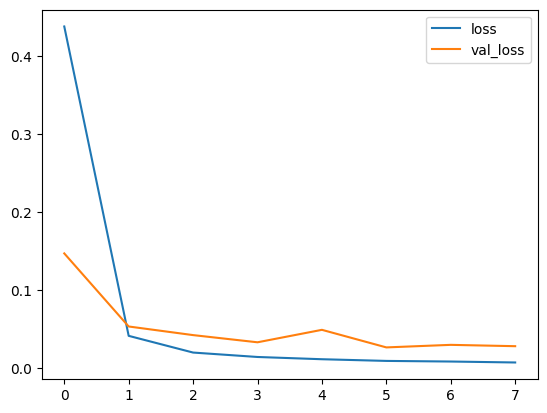

In [12]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

MAX_EPOCHS = 30
history = compile_and_fit(dense, single_step_window, MAX_EPOCHS=MAX_EPOCHS)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

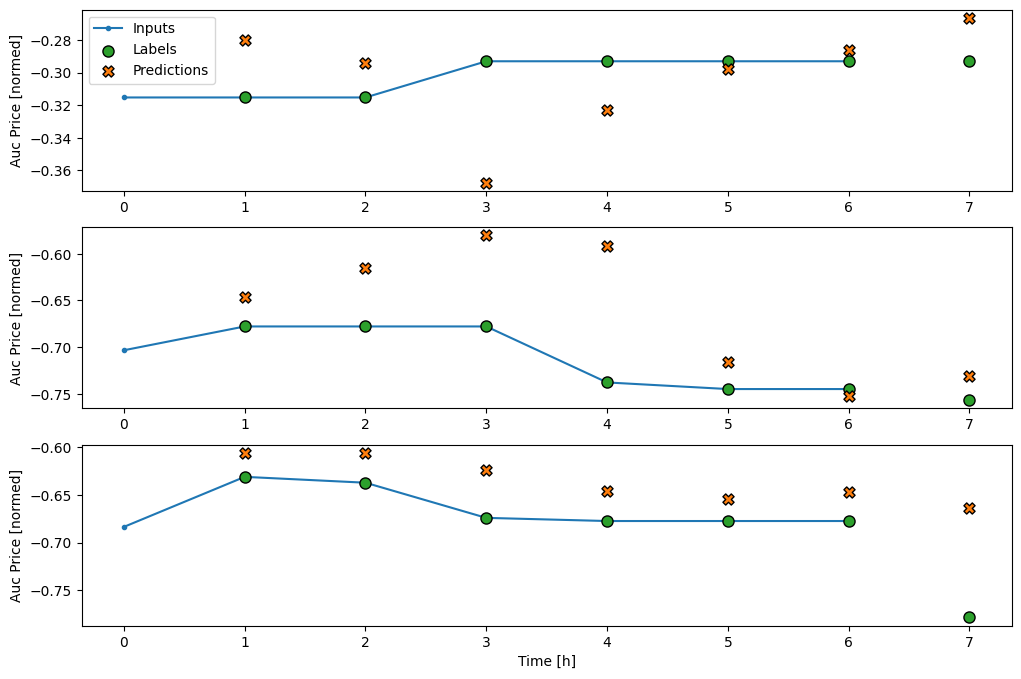

In [13]:
wide_window.plot(dense, plot_col=LABEL_COL)

### MULTISTEP DENSE

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 0.0660 - mean_absolute_error: 0.2024


Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

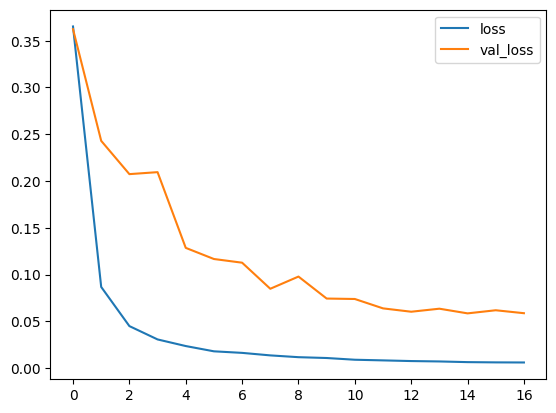

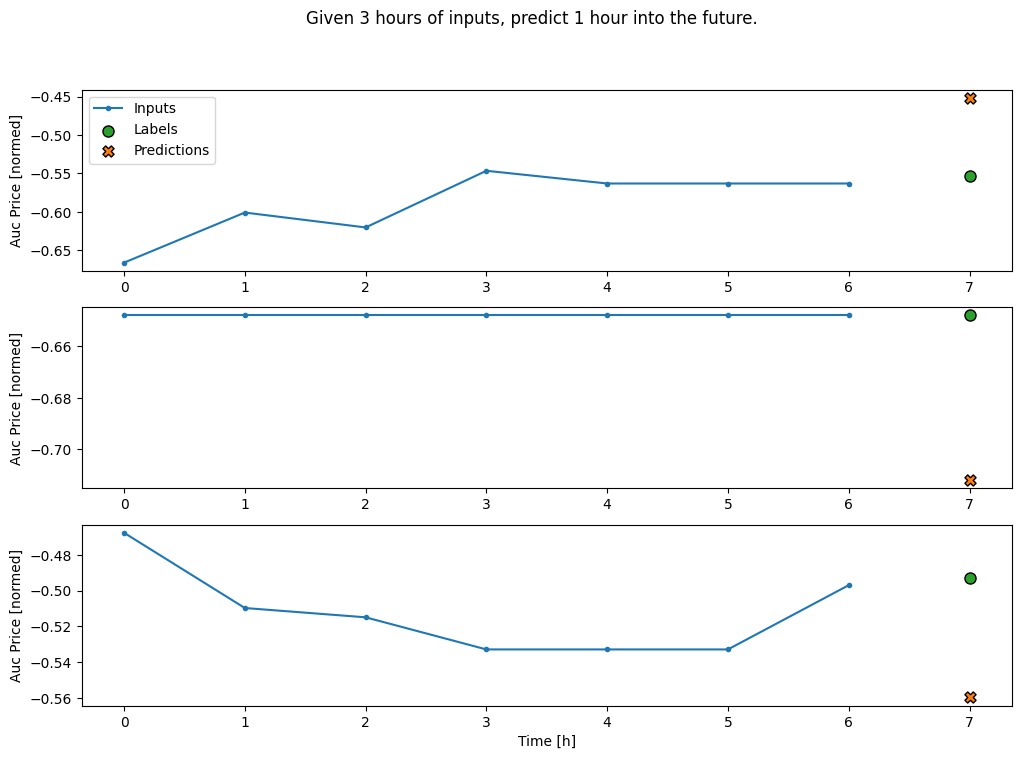

In [14]:
INPUT_STEPS = 7
conv_window = WindowGenerator(
    input_width=INPUT_STEPS,
    label_width=1,
    shift=1,
    label_columns=LABEL_COLS,
    train_df=train_df,
    test_df=test_df,
    val_df=val_df
    )

print(conv_window)
# conv_window.plot()
# plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)
history = compile_and_fit(multi_step_dense, conv_window)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)
conv_window.plot(multi_step_dense, plot_col=LABEL_COL)
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

In [15]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 7, 22)
Output shape: (32, 1, 1)


### CONV MODEL

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 0.0222 - mean_absolute_error: 0.1221


Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

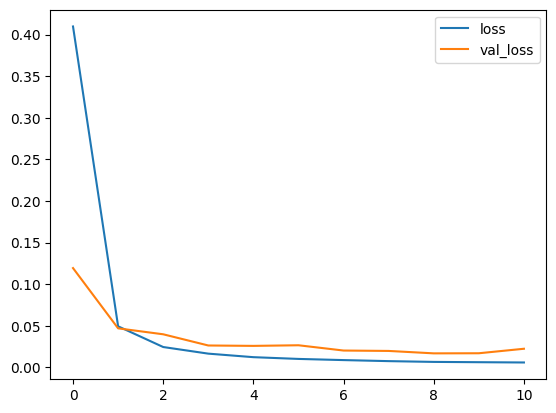

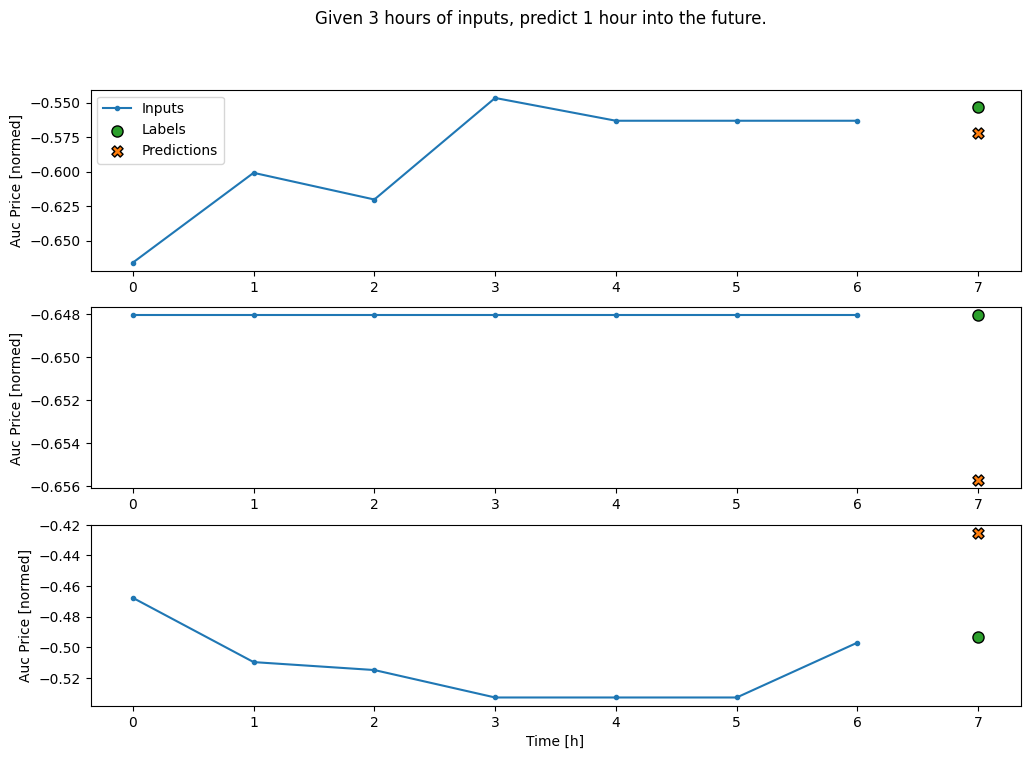

In [16]:

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(INPUT_STEPS,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

history = compile_and_fit(conv_model, conv_window)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)
conv_window.plot(conv_model, plot_col=LABEL_COL)
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

In [17]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 7, 22)
Labels shape: (32, 7, 1)
Output shape: (32, 1, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a WindowGenerator to produce wide windows with a few extra input time steps so the label and prediction lengths match:

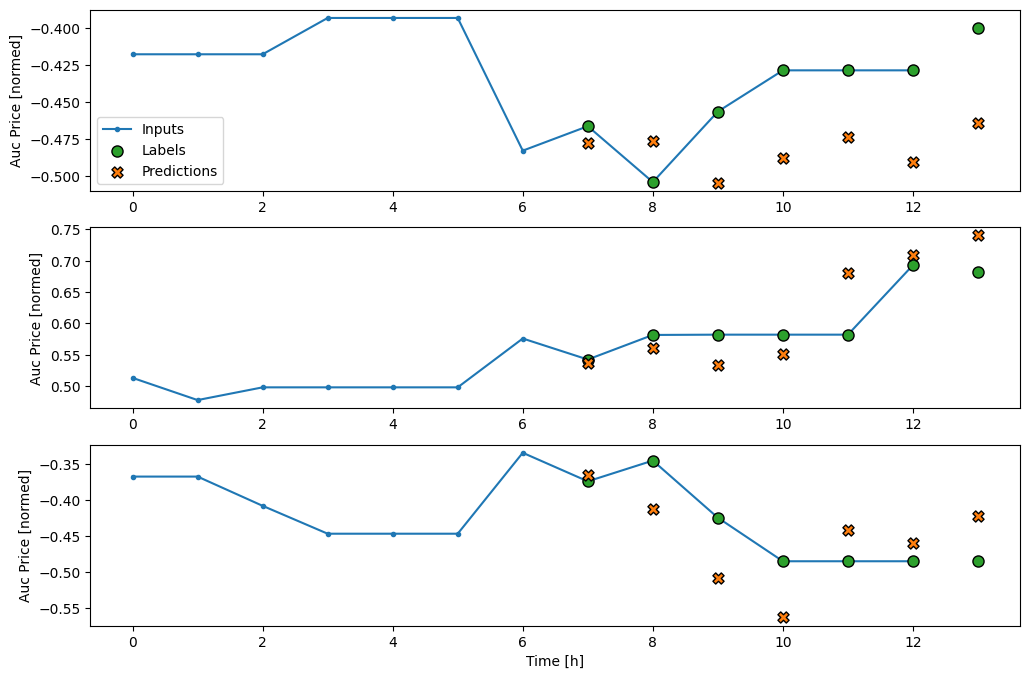

In [19]:
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + (INPUT_STEPS - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    train_df=train_df, test_df=test_df, val_df=val_df,
    label_columns=LABEL_COLS)

wide_conv_window.plot(conv_model, plot_col=LABEL_COL)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 0.0219 - mean_absolute_error: 0.1143


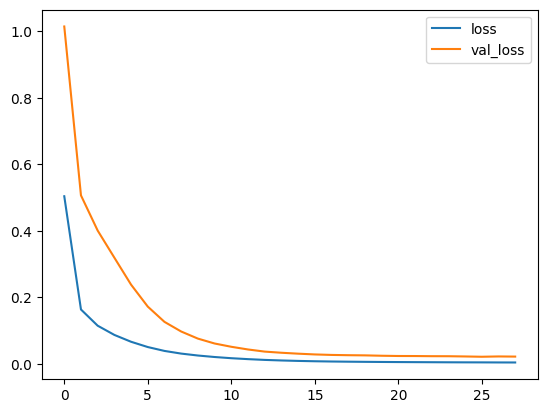

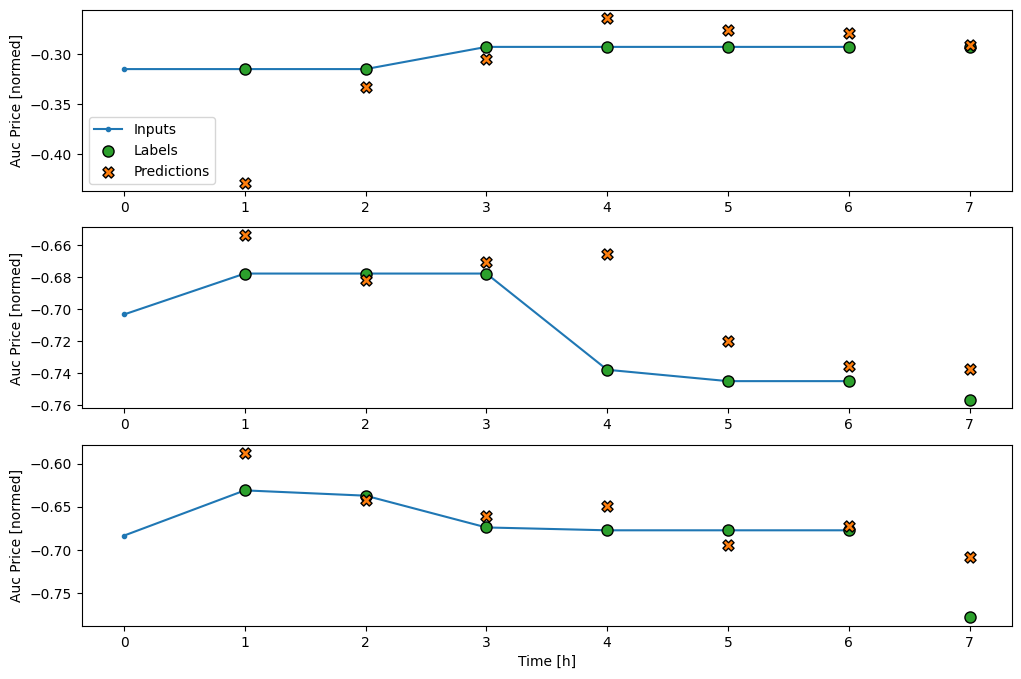

In [26]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

history = compile_and_fit(lstm_model, wide_window, MAX_EPOCHS=50)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)
wide_window.plot(lstm_model)


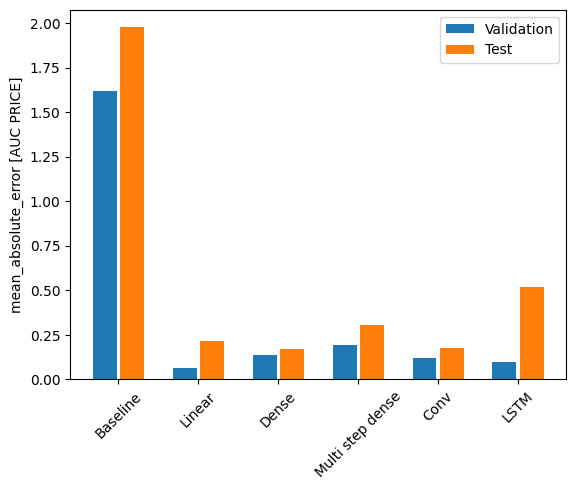

In [25]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error [AUC PRICE]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [31]:

single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1,
    train_df=train_df, test_df=test_df, val_df=val_df)

wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1, 
    train_df=train_df, test_df=test_df, val_df=val_df)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0, return_dict=True)

# DENSE MODEL
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=NUM_OF_FEATURES)
])

history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

## RNN 

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=NUM_OF_FEATURES)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0, return_dict=True)

print()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 0.3853 - mean_absolute_error: 0.3570



### REISDUAL LSTM

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 0.2640 - mean_absolute_error: 0.2171


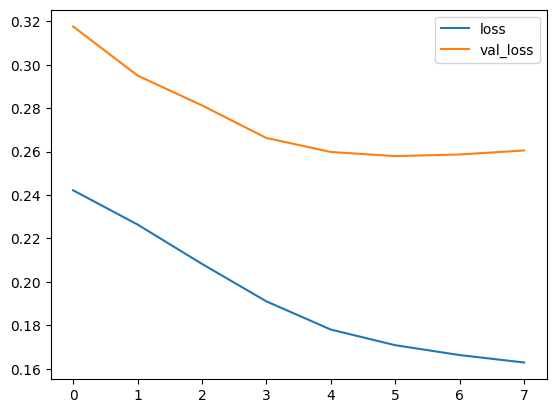

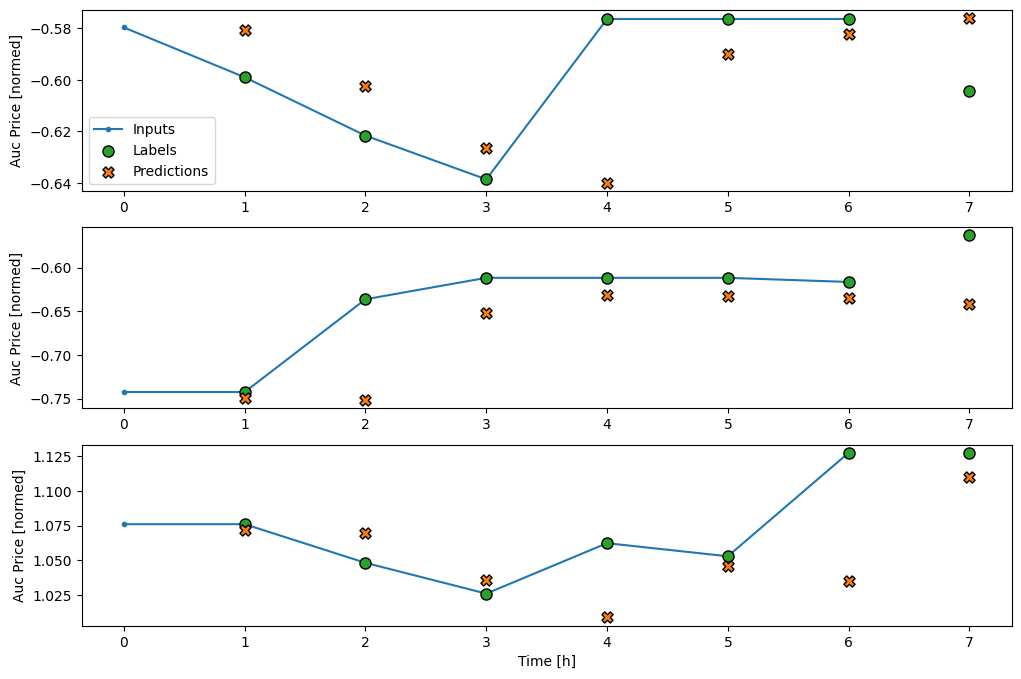

In [34]:

class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta
  

residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        NUM_OF_FEATURES,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)
wide_window.plot(residual_lstm)

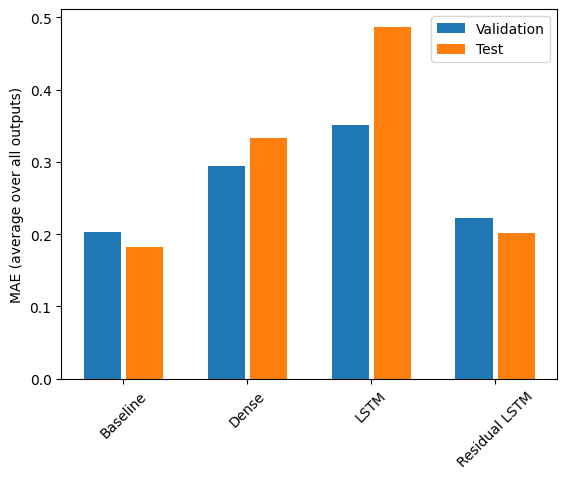

In [33]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()